## 概要

[kaggleのタイタニック](https://www.kaggle.com/c/titanic)を実際にやってみて、機械学習のフローを体験してみましょう。  
機械学習で出てくるフローについて、浅く広く記述しました。  

## 目次

- 1.タスクとデータの概要を確認する(EDA)  
    - 1-1.タスクの概要　　
    - 1-2.データの中身を確認  
    - 1-3.欠損値やデータ型の確認　　
- 2.特徴量エンジニアリング  
    - 2-1.カテゴリカル型
        - 欠損値の扱い
        - one-hot-encoding  
        - Target-encoding
    - 2-2.数値型
        - 欠損値の扱い
        - ビンニング      
        - 標準化
    - 2-3.特徴量選択
        - 特徴量間の相関を確認
    - 2-4.次元削減
        - 主成分分析(PCA)
- 3.モデルを学習＆評価  
    - 3-1.検証方法の検討
        - 交差検証
    - 3-2.モデリング
        - 決定木分析
        - ハイパーパラメータのチューニング  
            - GridSearch
        - catboost  
        - Neural Network(option)

## 1.タスクとデータの概要を確認する(EDA:Exploratory Data Analysis)

何はともあれ、最初は「どんなことをするのか」、「どんなデータなのか」といったことを確認することが重要です。  

#### 1-1.タスクの概要

今回は「titanic」の乗船客について「どういった乗客が生き残れるのか」といったことを予測できるか、といったタスクです。  
最終的には「生き残れるか否か」を予測することにするので、「2値分類」と言われるタスクを実施します。  

>In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. 
>In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

参照:[Competition Description](https://www.kaggle.com/c/titanic)

## 1-2.データの中身を確認

まずはデータの中身を色々と目視で確認していきましょう。

In [1]:
## パッケージのimport

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

/Users/yoshimura.keta/.local/share/virtualenvs/ml_handson-4_AMT-pk/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


まずはデータの形状を確認してみましょう。  
今回使うデータは「891行、12列」のテーブルデータです。

In [2]:
# dataの読み込み
df_train = pd.read_csv('data/train.csv')
df_train.name = 'train-data'

# dfの形状を確認する関数
def check_shape_of_df(df:pd.DataFrame):
    print('行数:{}'.format(df.shape[0]))
    print('列数:{}'.format(df.shape[1]))
    
# 確認
check_shape_of_df(df_train)

行数:891
列数:12


続いて、データの列名を確認しましょう。  
今回予測対象となるのは「Survived」という列(0,1の2値分類)です。

In [3]:
print('データの列名一覧')
print(df_train.columns)

データの列名一覧
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


続いて、実際にデータの中身を見てみましょう。  
今回予測対象となる「Survived」は「0,1」のいずれかが入っています。  
これ以外の特徴量を用いて「Survived」が0,1のいずれなのかを予測する、というのが今回の目的です。

In [4]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1-3.欠損値やデータ型の確認

続いて、各列に欠損値がないか、どのようなデータが入っているのかを確認しましょう。  

### ☆欠損値
なぜ欠損値を確認するのかと言うと、<span style="color: red; ">「最終的に作成するモデルの精度に大きく影響する」ためです。</span>  
例えば、モデルによっては欠損値があると意図した通りに動作しなかったり、「欠損値をいい感じに補填すると、モデルの精度が高まったり」します。  
また「欠損値が多いデータはそもそも使わない」といった方針を立てることもあります。  

今回使うデータには<span style="color: red; ">「Age」に177レコード、「Cabin」には687レコード、「Embarked」に2レコードの欠損があるみたいです。</span>  

「Cabin」については欠損値が多すぎるので、今回は「Cabin」変数は使わないことを検討することとします。  
（アルゴリズムによっては欠損値があっても問題ないアルゴリズムもあるので、そのような場合は欠損値の割合が大きい列も使えます）  

また、それ以外の特徴量については「欠損値を何かしらの値で補填」することで利用することとします。  
「欠損値の補填方法」については色々ありますが、原則は「データの分布を確認」する必要がありますが、「最頻値」、「中央値」、「平均値」等で補填することが多いです。

In [5]:
print('データ型、欠損していない行数の確認')
df_train.info()

データ型、欠損していない行数の確認
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


続いて、どんなデータが入っているかを確認しましょう。  
今回使うデータの各列の内容については、下記の通りです。  
これは、データを扱う上で必ず「データ定義」を確認すると思いますが、それと同じです。



- PassengerId
    - 乗客ID。数値型だが、ただ顧客を区別するためだけのものなので、今回は考慮不要。
- Survived
    - 今回の目的変数
    - 船の沈没後に対象の乗客が生存していたかどうか。生存していた場合は1、そうでない場合は0が入る。
    - 0,1のいずれかの値が入る。
- Pclass (Passenger Class)
    - チケットを3クラスに分割したもの
    - 1,2,3のいずれかの値が入る
    - 1が一番高い、3が一番低い
- Name
    - 乗客の名前
- Sex
    - 乗客の性別
- Age 
    - 乗客の年齢
- SibSp
    - 親族の同時乗客客数
    - 「PassengerId」の乗客がチケットを購入した場合でも、複数人（家族等）で乗客していたりするので、その人数
- Parch
    - 乗客の親族関係
    - もし乗客間で血縁関係が無い場合（ex.赤子と乳母）は0が入る
- Ticket
    - チケット番号
- Fare
    - 乗客料金
- Cabin
    - cabinの番号
- Embarked
    - 乗客した港
    - C,Q,Sのいずれかの値が入る。
    - C = Cherbourg, Q = Queenstown, S = Southampton

続いて、もう少し詳しくデータの中身を見て、「どんなデータか」といった肌感覚を掴みましょう。  
注意点は<span style="color: red; ">「カテゴリ型データに偏りがないか」、「数値型で分布がどんな形か（外れ値とか）」といった点です。</span>  

もしカテゴリ型データに偏りがある場合は「学習時のデータ分割方法に気をつける(Over-Sampling, Under-Sampling)」、「データ拡張を検討する」、「2値分類ではなく異常検知にする」等色々と検討することがあります。  

また、<span style="color: red; ">「外れ値」が存在すると、「モデルの学習が外れ値の影響を強く受けてしまう」ことがあるため、「外れ値は削除」する等の対応が必要となります。</span>

In [6]:
# カテゴリカル型特徴量の確認
def pd_series_value_counts(df:pd.DataFrame,target_column:str):
    print('=' * 20 + f'{target_column}' + '=' * 20)
    print(df[target_column].value_counts())

# 数値型特徴量の確認
def pd_series_describe(df:pd.DataFrame,target_column:str):
    print('=' * 20 + f'{target_column}' + '=' * 20)
    print(df[target_column].describe())


# Survived
# 0,1の値の割合に偏りがある（生存者が全体の1%しかいない、とか）場合は、「アンダーサンプリング」や「異常検知」等の対応を取る必要があります。
pd_series_value_counts(df=df_train,target_column='Survived')

# Pclass
# 1,2,3の比率はだいたい２：１：１。
pd_series_value_counts(df=df_train,target_column='Pclass')

# Name
# 人の名前なので、バラバラです...。
pd_series_value_counts(df=df_train,target_column='Name')

# Sex
pd_series_value_counts(df=df_train,target_column='Sex')

# Age
pd_series_describe(df=df_train,target_column='Age')

# SibSp
pd_series_value_counts(df=df_train,target_column='SibSp')

# Parch
pd_series_value_counts(df=df_train,target_column='Parch')

# Ticket
pd_series_value_counts(df=df_train,target_column='Ticket')

# Fare
pd_series_describe(df=df_train,target_column='Fare')

# Cabin
pd_series_value_counts(df=df_train,target_column='Cabin')

# Embarked
pd_series_value_counts(df=df_train,target_column='Embarked')

====================Survived====================
0    549
1    342
Name: Survived, dtype: int64
====================Pclass====================
3    491
1    216
2    184
Name: Pclass, dtype: int64
====================Name====================
Paulner, Mr. Uscher             1
Reeves, Mr. David               1
Zabour, Miss. Hileni            1
Lewy, Mr. Ervin G               1
Dahlberg, Miss. Gerda Ulrika    1
                               ..
Carlsson, Mr. Frans Olof        1
Oreskovic, Mr. Luka             1
Marvin, Mr. Daniel Warner       1
Douglas, Mr. Walter Donald      1
McGough, Mr. James Robert       1
Name: Name, Length: 891, dtype: int64
====================Sex====================
male      577
female    314
Name: Sex, dtype: int64
====================Age====================
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64
====================

## 余談

各レコードを見て何か気づくことはありましたでしょうか？  
筆者は下記の点が気になりました。  
今回は考慮しませんが、下記の特徴量が有効か、検討してみてもいいかもしれません。  
(どうでも良さそうだし、面倒臭いものばかりですが、テーブルデータで機械学習をしようとすると得てしてこのようなことを確認していく必要性が出てくるものです)

- 「Name」の「Mr.」、「Miss」は何かしらの生存確率に影響しうる可能性があるので、特徴量化してもいいかもしれない
    - 結婚しているか否か、で例えば人の脂肪率が異なる場合があり、船が沈没した後の生存率に影響する云々
- 「Ticket」の頭に入っている「PC」とか「CA」ってなんだろう
    - 例えば、「ご招待枠」とかだったりしたらいいキャビンに誘致されていて（救命ボート付きとか）、生存確率に影響している、とか
- 「Ticket」の数字の一文字目が1,2,3のいずれか？もしかしらキャビンの階数を表す？
    - 生存確率に影響していそう？
- 「Cabin」のアルファベットと数字は何を意味するのか
    - 実はアルファベットにはある意味があります。

TitanicのCabinについて

![alt text](https://vignette.wikia.nocookie.net/titanic/images/f/f9/Titanic_side_plan.png/revision/latest?cb=20180322183733)

## 2.特徴量エンジニアリング

ここまで確認してきた内容を元に、実際にモデリングに使うための特徴量を作成しましょう。  
テーブルデータで特徴量を作成する際は、対象とするデータが「数値型」、「カテゴリカル型」のいずれなのか、といった点に注意する必要があります。  

## 2-1.カテゴリカル型

<span style="color: red; ">数字じゃなくて、「性別」とか「居住都道府県」とかそういった「カテゴリー」として扱うべき特徴量を「カテゴリカル型」と表現します。</span>  
機械学習の中で例えば「性別=男」といったデータがあっても数字として計算できないので、計算できるように変換する必要があります。  

今回はカテゴリカル型の扱い方について、よく遭遇するであろう下記の3点を見ていきます。  
- 欠損値の扱い
- one-hot-encoding
- Target-encoding

## 欠損値の扱い
まずは欠損値をどうにかしましょう。  
欠損値をいい感じに処理することのメリットは下記の通りです。  

- 欠損値が存在すると、モデルの学習がうまくいかないことがある。その場合は何かしらの値で補填したり、そもそもそのデータを使わないようにする必要がある
    - アルゴリズムによっては欠損値があっても学習できるものもありますが、そのような場合も補填した場合とそうでない場合での比較をしましょう
- 欠損値があるデータが予測にとても有効だった場合は、何かしらの値で欠損値を補填することで推論精度の向上に繋がりうる
    - カテゴリカル型の場合は「最頻値」で補填することが多い。ただ、カテゴリカル型は本当に多様（面倒臭い）なので、扱いが面倒臭い
    - 欠損していることそれ自体に何かしらの意味がある場合もある

In [7]:
# Cabinについては欠損値が多いので、今回は使わない
df_train.drop(columns='Cabin', inplace=True)

## Embarkedは最頻値で補填
df_train.Embarked.fillna(df_train.Embarked.mode(), inplace=True)

## one-hot-encoding

下記のような変換を行う処理です。  
<span style="color: red; ">文字データやカテゴリ型のデータは、そのままでは機械側で計算できないので、計算できるように「0,1」の形に変換するものです。</span>  
注意点として、<span style="color: red; ">「全てのカテゴリを列として変換する必要はなく、1つだけ列として保持しない方がいい」</span>という点です。  
(削除した1つの列の値を基準値として、それ以外の値だとどのような重みになるか、といった計算をするためです)


例えば下記の例では「male」、「female」をそれぞれ特徴量として変換していますが、どちらか１つだけにした方がベターです。  


・修正前

| ID  | sex    |
| --- | ---    |
| 1   | male   |
| 2   | female |
| 3   | female |
| 4   | male |


・修正後

| ID  | sex_male | sex_female |
| --- | --- | --- |
| 1   | 1   | 0 |
| 2   | 0   | 1 |
| 3   | 0   | 1 |
| 4   | 1   | 0 |



In [8]:
# 今回は「Pclass」、「Parch」、「sex」、「embarked」をOne-HotーEncodingします

df_train = pd.get_dummies(df_train, drop_first=True, columns=['Pclass', 'Parch', 'Sex', 'Embarked'])

# どのように処理されたかを確認
df_train.head()

,PassengerId,Survived,Name,Age,SibSp,Ticket,Fare,Pclass_2,Pclass_3,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Sex_male,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,A/5 21171,7.2500,0,1,0,0,0,0,0,0,1,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,PC 17599,71.2833,0,0,0,0,0,0,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,STON/O2. 3101282,7.9250,0,1,0,0,0,0,0,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,113803,53.1000,0,0,0,0,0,0,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,373450,8.0500,0,1,0,0,0,0,0,0,1,0,1


## Target-encoding  

続いて、「Target-Encoding」という特徴量生成手法を見てみましょう。  
今回のハンズオンでは実施しませんが、この手法は<span style="color: red; ">「各特徴量とTargetとなるクラスとの関係性」を特徴量に落とし込むものです。</span>   
例えば「labelが0,1のいずれか」ということを予測するタスクの場合に、下記のような変換をします。


こんなデータに対して...

| category  |  label  |  
| --- | --- |
| A | 1 |
| A | 0 |
| B | 1 |
| B | 0 |
| B | 0 |
| C | 1 |
| C | 1 |
| C | 1 |
| C | 0 |


こんな特徴量を作成する(new列)  
(各カテゴリーごとのlabel=1の割合)

| category  |  label  | new  |  
| --- | --- | --- |
| A | 1 | 0.5   |
| A | 0 | 0.5   |
| B | 1 | 0.33  | 
| B | 0 | 0.33  |
| B | 0 | 0.33  |
| C | 1 | 0.75  | 
| C | 1 | 0.75  | 
| C | 1 | 0.75  | 
| C | 0 | 0.75  | 


しかし、これは<span style="color: red; ">「答えを使って答えを予測する」ようなものなので、取り扱い方に注意しないと「Leakage」と言われる事象が発生してしまいます。</span>   
(カンニングみたいなものです。なので、やり方を間違えると「検証＆テストデータでもいい精度がでたー」と思ってしまいますが、汎化性能が低いモデルができてしまいます)


対応方法は下記のようなものがあるのですが、「Leakageに不安がある」場合は、無理して使わなくてもいいかと思います。  
（慣れるまでは使い方に気をつけて！！！）

- 学習用データでこの列を作成して、valid＆testにはこの学習用データで作成した値を入れ込む
- 対象のレコード以外のレコードで計算する。
    - しかし、このやり方でも多クラス分類の際に、あるクラスのレコード数が少ないときはこのやり方でもLeakageが発生してしまう
    - そのため[smoothing](https://mikebird28.hatenablog.jp/entry/2018/06/14/172132)という考え方も組み合わせた「Target-encoding」も使われている


In [ ]:
## 今回は使いませんが、Target-Encodingのサンプルスクリプトです
## trainデータで作成した値を、validation,testデータセットに適用しています
## 汚いですが...
"""
def target_encoding(X_train:pd.DataFrame, X_valid:pd.DataFrame, X_test:pd.DataFrame):

    X_train = X_train.assign(target_enc_type_id_mean = X_train.groupby('category')['target'].transform('mean').copy())
    X_train = X_train.assign(target_enc_type_id_std = X_train.groupby('category')['target'].transform('std').copy())
    X_train = X_train.assign(target_enc_type_id_median = X_train.groupby('category')['target'].transform('median').copy())

    ## validに同じ値を適用
    _ = X_train.loc[:,['category','target_enc_category_mean']].drop_duplicates()
    X_valid = pd.merge(X_valid, _ , how = 'inner', left_on = 'category', right_on = 'category')
    _ = X_train.loc[:,['category','target_enc_category_std']].drop_duplicates()
    X_valid = pd.merge(X_valid, _ , how = 'inner', left_on = 'category', right_on = 'category')
    _ = X_train.loc[:,['category','target_enc_category_median']].drop_duplicates()
    X_valid = pd.merge(X_valid, _ , how = 'inner', left_on = 'category', right_on = 'category')
    
    ## testに同じ値を適用
    _ = X_train.loc[:,['category','target_enc_category_mean']].drop_duplicates()
    X_test = pd.merge(X_test, _ , how = 'inner', left_on = 'category', right_on = 'category')    
    _ = X_train.loc[:,['category','target_enc_category_std']].drop_duplicates()
    X_test = pd.merge(X_test, _ , how = 'inner', left_on = 'category', right_on = 'category')
    _ = X_train.loc[:,['category','target_enc_category_median']].drop_duplicates()
    X_test = pd.merge(X_test, _ , how = 'inner', left_on = 'category', right_on = 'category')


    return X_train, X_valid, X_test
"""    

## 2-2.数値型
数値型の特徴量を扱う際によく発生する処理について、取り扱っていきます。  

- 欠損値の扱い
    - 欠損値をいい感じに補填すると、推論精度が高まることがあるよ
- ビンニング
    - 数値をそのまま使うのではなく、ある程度の単位でまとめて「カテゴリカル型」にしてしまうことも有効だよ
- 正規化
    - 数値型のデータをそのまま使っちゃうと、「他の特徴量に悪影響がでる」可能性があるから注意しよう！   

## 欠損値の扱い
欠損値が存在するデメリットは「カテゴリカル型」と同じです。  
数値型の場合は「最頻値」、「中央値」、「平均値」で補填することが多いです。  
ただ、そのやり方はあくまでも「こうやる場合が多い」というだけで、もっといい補填方法は場合によりけりです。

In [9]:
"""
「Age」、「Fare」は中央値で補填。
"""

df_train.Age.fillna(df_train.Age.median(),inplace=True)

## ビンニング

「ビンニング」とは<span style="color: red; ">「数値型データをある程度の単位でまとめてカテゴリカル型変数に変換する処理」</span>のことを言います。  
例えば、「年齢」という特徴量を10才単位でまとめて「年代」とするような処理です。  

この処理は<span style="color: red; ">「特徴量と目的変数の間に非線形の関係があり、かつ線形回帰を使いたい」</span>場合に使います。  
(このイメージについては、下記の相関係数と棒グラフをご参照ください)


この処理をすると<span style="color: red; ">「元は生の数値だったのにある程度のグループ数にまとめてしまう」ので、「表現力が落ちてしまう」</span>といった点に注意する必要があります。  
そのため、<span style="color: red; ">「決定木分析」や「非線形のアルゴリズム(Neural Network等)」を使う場合は逆効果になりやすいため、使わない方がいい場合もあります。</span>  
今回は「決定木分析」を使うのでビンニングをする必要はないのですが、参考までにやってみましょう。

In [10]:
# 相関はそこまで高く無い(線形の関係性が弱い)

df_train.loc[:,['Fare','Survived']].corr()

,Fare,Survived
Fare,1.000000,0.257307
Survived,0.257307,1.000000


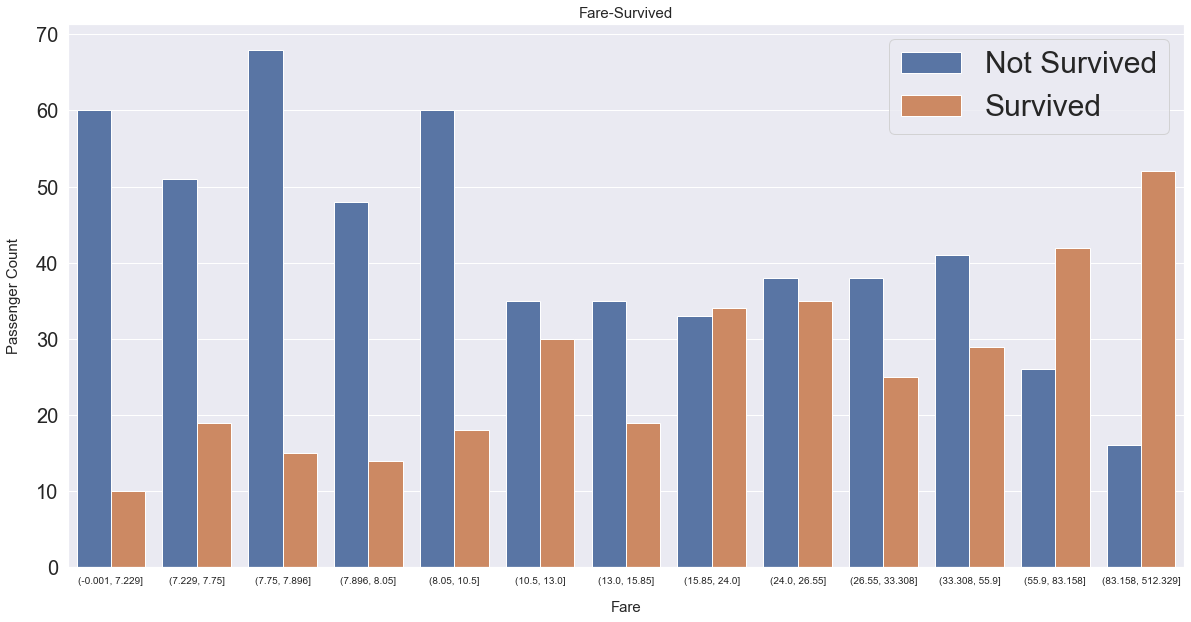

In [11]:
## しかし、Survivedに関係はありそう...(非線形の関係性はありそう)
"""
Fareが「10.5-13.0」の間ではSurvivedの割合が高まっていますが、
その後に一回下がって、また上がって、下がって、となっているので線形の関係性ではなさそうですね。
"""


def check_features_and_survived_relation_by_count(df:pd.DataFrame, src_feature:list, n_bin:int):
    _ = df.copy()
    _[src_feature] = pd.qcut(x=_[src_feature], q=n_bin)
    fig, axs = plt.subplots(figsize=(20, 10))
    
    sns.countplot(x=src_feature, hue='Survived', data=_)
    plt.xlabel('Fare', size=15, labelpad=15)
    plt.ylabel('Passenger Count', size=15, labelpad=15)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=20)
    plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 30})
    plt.title(f'{src_feature}-Survived', size=15, y=1.0)
    plt.show()
    
    
check_features_and_survived_relation_by_count(df=df_train, src_feature='Fare', n_bin=13)

「Age」も「Fare」と同じ...

In [12]:
## 相関はそんなに強く無い(相関の関係は弱い)

df_train.loc[:,['Age','Survived']].corr()

,Age,Survived
Age,1.00000,-0.06491
Survived,-0.06491,1.00000


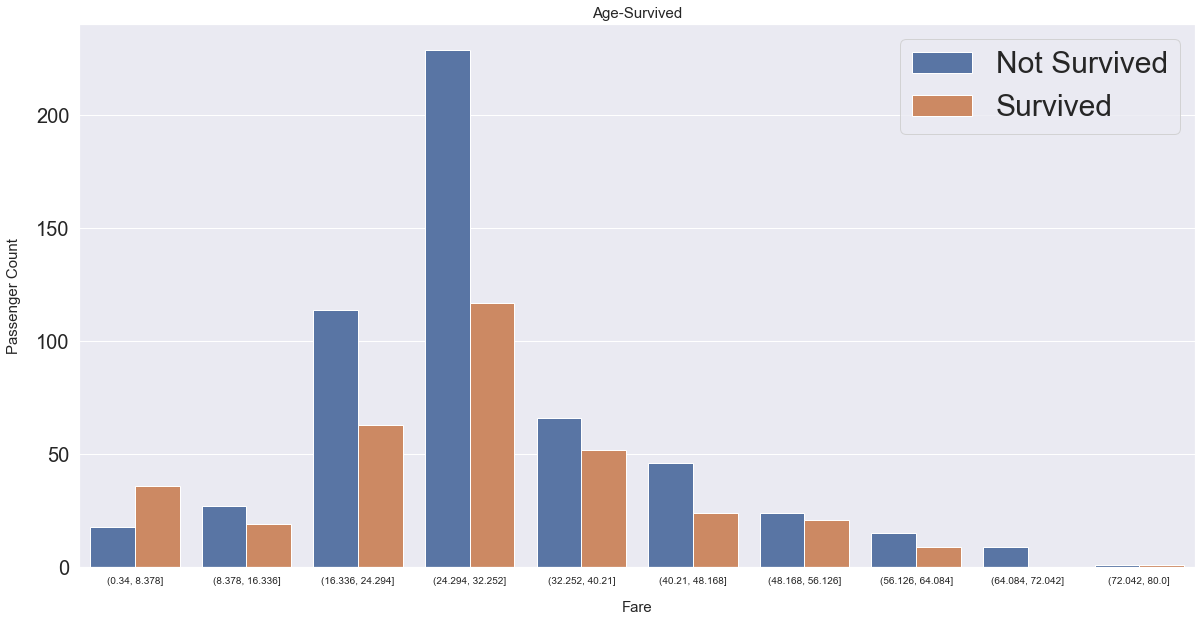

In [13]:
## しかし、Survivedに関係はありそう...(非線形の関係性)
   
def check_features_and_survived_relation_by_count(df:pd.DataFrame, src_feature:list, n_bin:int):
    _ = df.copy()
    _[src_feature] = pd.cut(x=_[src_feature], bins=n_bin, )
    fig, axs = plt.subplots(figsize=(20, 10))
    
    sns.countplot(x=src_feature, hue='Survived', data=_)
    plt.xlabel('Fare', size=15, labelpad=15)
    plt.ylabel('Passenger Count', size=15, labelpad=15)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=20)
    plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 30})
    plt.title(f'{src_feature}-Survived', size=15, y=1.0)
    plt.show()

check_features_and_survived_relation_by_count(df=df_train, src_feature='Age', n_bin=10)

In [14]:
## Fare,Ageについてビンニングする

## parameter
n_bin = 10


## 関数
def binning_target_feature(target_feature:str, n_bin:int):
    _ = pd.cut(x=df_train[target_feature], bins=n_bin, retbins=True)
    df_train[target_feature] = pd.cut(x=df_train[target_feature], bins=_[1])
    
    return df_train


## binning
df_train = binning_target_feature(target_feature='Fare', n_bin=n_bin)
df_train = binning_target_feature(target_feature='Age', n_bin=n_bin)


## one-hot-encoding
df_train = pd.get_dummies(df_train, drop_first=True, columns=['Fare', 'Age'])

In [15]:
# 確認
df_train.head(3)

,PassengerId,Survived,Name,SibSp,Ticket,Pclass_2,Pclass_3,Parch_1,Parch_2,Parch_3,...,"Fare_(461.096, 512.329]","Age_(8.378, 16.336]","Age_(16.336, 24.294]","Age_(24.294, 32.252]","Age_(32.252, 40.21]","Age_(40.21, 48.168]","Age_(48.168, 56.126]","Age_(56.126, 64.084]","Age_(64.084, 72.042]","Age_(72.042, 80.0]"
0,1,0,"Braund, Mr. Owen Harris",1,A/5 21171,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,PC 17599,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",0,STON/O2. 3101282,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## 正規化(正則化とは言葉が似ているけど別物だよ！！！)
「正規化」とは<span style="color: red; ">数値を何かしらのルールに基づいて変換する処理を意味します。</span>  
例えば、正規化の中でも「Min-MaxScaling」と言われる手法は対象の数値に対して下記のような処理を行います。  

$ (対象の数値 - MIN) / (MAX - MIN)

・変換例

変換前:[0,3,5,10]  
変換後:[0.0,0.3,0.5,1.0]  

なぜこんなことをするのかというと、<span style="color: red; ">「複数の特徴量間で、数字のスケールが異なる(ex.年収と体重)」場合に「等しいスケールにすることで平等に評価できるようにする」、「外れ値の影響を小さくする」</span>ためです。  
例えば、<span style="color: red; ">「y=a×<年収>+b×<身長>」といった形で何かしらのyを予測する際、単位が揃っていないと「aとbの数字もスケールが異なってきてしまう」ため、比較することが難しくなってしまいます。</span>  
(なので、実施する場合は数値型特徴量全てに対して実施することになります。特定のカラムだけに実施することは殆ど無いです)


また、よくある誤解として下記のようなものがあるので注意しましょう。  
- 数値データを使う場合は必ず正規化しないといけないんだよね？
    - そんなことない。例えば、決定木系のアルゴリズムを使う場合は正規化する意味はない。
- 正規化って要するに標準化のことでしょ？
    - 大きな枠組みとして「正規化」があり、その中の具体的な方法の中で「Min-MaxScaling」や「標準化(normalize)」、「中心化(centering)」等がある
- とりあえず標準化しておけばいい?
    - 標準化はそのデータが「自然分布に沿っている」ことを前提としています
    - その点を考慮した上で実施するのならいいのですが、別に標準化は万能な手法ではないです
    - とは言え、とりあえず標準化で対応、となることが多いのも事実かな、とは思います...

**今回は正規化が必要な数値型特徴量がもう残っていないので、特に正規化はしません**

## 2-3.特徴量選択

<span style="color: red; ">特徴量が多すぎると、モデルの学習に悪影響が生じる可能性があります。</span>  
(主に、モデルの汎化性能に悪影響が生じる)  
具体的には、下記のような問題が発生する可能性があります。  

- 本来は精度に全く寄与しない特徴量に対しても少しながら重み付けがされることで、モデルの汎化性能が低下する
- 無駄な特徴量を使うと、学習が収束しづらい（モデルの学習が不安定になる）
- 「同じような意味を持つ特徴量が複数存在」する場合は、本来なら1つの特徴量の重みを学習すればいいところを「わざわざそれぞれの特徴量に重みを振り分けて」学習を進めてしまうために、汎化性能が低下する
- データ数と特徴量数が一致するくらい特徴量が多い場合、「特徴量ごとに何かしら特定の重みを割り振る」ことで完全な推論をすることができてしまう
    - 当然、これは新しくきたデータに対する推論能力が低く、汎化性能が低いので使い物にならない


一般的に、<span style="color: red; ">同じような結果が得られるのであれば、「使う特徴量は少なければ少ないほどいい」</span>のです。  

## 特徴量選択の方法

色々あります。  
最近はモデルのアルゴリズムの中で選択してくれるものもありますね。  
<span style="color: red; ">ニューラルネットワークも「特徴量選択を自動でネットワークの中でやってくれる」という言論で話され、「特徴量選択は不要」という意見も出ています。</span>  
（とりあえず特徴量いっぱいツッコンどきゃいいだろ、ネットワークが学習する過程で不要な特徴量の重みは0にしてくれる！！！という考え）  

しかしながら、上記で述べた理由以外にも<span style="color: red; ">「理論的にはニューラルネットワークで不要な特徴量の重みを0にできそうだが、現実的にやるとなるとかなりの回数のトライ＆エラーが必要となる」、「そのトライ＆エラーが結局学習を収束させるために特徴量選択を実施した」とかだったりするので、「最初から特徴量選択した方が早いし確実だし楽じゃね？」という意見もあります。</span>  

今回は簡単に「同じような意味合いを持つ特徴量の排除」を目的として、「全特徴量間(目的変数以外)の相関」を確認し、相関係数が高い特徴量を削除します。    

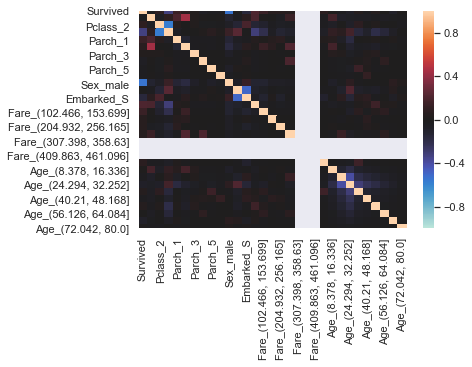

In [16]:
# 利用するカラムのみで計算

_  = df_train.drop(columns=['PassengerId', 'Name' ,'Ticket']).corr(method='pearson')
sns.heatmap(_, vmax=1, vmin=-1, center=0)

In [17]:
# 相関係数の絶対値が、指定した閾値以上である列を削除する関数

# parameter
threshold_correlation = 0.8


def check_corr_between_columns(thr:float, df_train:pd.DataFrame):
    
    _train = df_train.drop(columns='Survived')
    _train_y = df_train['Survived']
    
    corr_matrix = _train.corr().abs()
    
    # 相関行列の上半分だけを取得（上と下で同じものが出るので）
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # 削除するカラムのインデックスを取得
    to_drop = [column for column in upper.columns if any(upper[column] > thr)]
    
    _train.drop(to_drop, axis=1, inplace=True)
    
    ## 削除したカラムの一覧
    print(20*'=' + '削除したカラムの一覧' + 20*'=')
    print(to_drop)
    print(20*'=' + '残ったカラムの一覧' + 20*'=')
    print(df_train.columns)
    
    ## 変数削除後に、各変数とtargetの相関を確認しておこう
    print(50*'=' + 'TOP10' + 50*'=')
    print(np.abs(_train.corrwith(_train_y)).sort_values(ascending=False).head(10))
    print(50*'=' + 'warst10' + 50*'=')
    print(np.abs(_train.corrwith(_train_y)).sort_values(ascending=True).head(10))
    
    ## trainにtarget-labelを付与し直す
    _train = pd.concat([_train, _train_y], axis=1)
    return _train
    
df_train = check_corr_between_columns(thr=threshold_correlation, df_train=df_train)

====================削除したカラムの一覧====================
[]
====================残ったカラムの一覧====================
Index(['PassengerId', 'Survived', 'Name', 'SibSp', 'Ticket', 'Pclass_2',
       'Pclass_3', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5',
       'Parch_6', 'Sex_male', 'Embarked_Q', 'Embarked_S',
       'Fare_(51.233, 102.466]', 'Fare_(102.466, 153.699]',
       'Fare_(153.699, 204.932]', 'Fare_(204.932, 256.165]',
       'Fare_(256.165, 307.398]', 'Fare_(307.398, 358.63]',
       'Fare_(358.63, 409.863]', 'Fare_(409.863, 461.096]',
       'Fare_(461.096, 512.329]', 'Age_(8.378, 16.336]',
       'Age_(16.336, 24.294]', 'Age_(24.294, 32.252]', 'Age_(32.252, 40.21]',
       'Age_(40.21, 48.168]', 'Age_(48.168, 56.126]', 'Age_(56.126, 64.084]',
       'Age_(64.084, 72.042]', 'Age_(72.042, 80.0]'],
      dtype='object')
==================================================TOP10==================================================
Sex_male                   0.543351
Pclass_3           

## 2-4.次元削減

特徴量が多すぎることの弊害については上に書いたとおりです。  

しかしながら、特徴量選択も大変なので、<span style="color: red; ">「元々保持している情報量をできるだけ減らさずに、特徴量を減らす」</span> 方法についても研究されています。  
この手法のことを<span style="color: red; ">「次元削減」</span>とか言ったりします。  

具体的には、「主成分分析」、「Auto-Encoder」等のアルゴリズムが利用されます。  


## 3.モデルを学習＆評価  
前処理はここまでとして、ここからは実際にモデルを学習させていきましょう。  
ここで検討すべきは<span style="color: red; ">「どんなアルゴリズムで学習させるか」と「どのように評価するか」</span>の2点です。  

「どんなアルゴリズムで学習させるか」についてはある程度機械学習のアルゴリズムに詳しくなる必要があるので、勉強しましょう。  

## どんなアルゴリズムで学習させるか

機械学習のタスクをざっくり下記の３つに分類してみましょう。  
これは「昔から言われていた機械学習のタスク分類」方法です。  

- <span style="color: red; ">回帰</span>
    - 過去の傾向からある数値を予測する、等
    - SageMakerのビルトインアルゴリズムで言うと、[Linear-Learner](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/linear-learner.html)、[Xgboost](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/xgboost.html)、[k-nn](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/k-nearest-neighbors.html)
    - 時系列データでの回帰となると「時系列予測」という、独特の分野になる。基本的な考え方は変わらないが、注意点が色々増えるので難しい。
        - [Deep AR](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/deepar.html)
    - レコメンドも回帰して「スコア」を計算したりしている
        - [Factorizxation Machines](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/fact-machines.html)、[Object2Vec](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/object2vec.html)
    - 自然言語では「翻訳」等のタスクについて、「どの単語が来る可能性が高いか」といったことを予測している。
        - [Sequence to Sequence](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/seq-2-seq.html)
        - しかし、「Sequence to Sequence」を回帰、と呼ぶのはかなり無理やり感がありますが...
- <span style="color: red; ">分類</span>
    - 対象のデータがどのグループに属するか、を予測するタスク。「グループ」が事前に決まっていることが前提。（クラスタリングとの違い）
    - テーブルデータなら[xgboost](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/xgboost.html)、[Factorizxation Machines](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/fact-machines.html)、[k-nn](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/k-nearest-neighbors.html)、画像相手なら[image-classification](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/image-classification.html)
    - 分類クラス数が2つだけで、かつ割合に偏りがあるようなら「異常検知」と言われるタスクになる
        - テーブルデータに対してなら[Random-Cut-Forest](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/randomcutforest.html)や[IP Insight](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/ip-insights.html)
    - テキストの分類、というタスクもある
        - [Blazing text](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/blazingtext.html)
- <span style="color: red; ">クラスタリング</span>
    - 「分類」は「グループ数が決まっている」タスクだが、クラスタリングは「グループ数が決まっていないけど、いい感じに分けたらどうなるか」といったタスク。
    - 全くの別物なのだが、ニュアンスが似ているので注意
    - テーブルデータに対しての[k-means](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/k-means.html)、テキストデータに対しての[LDA](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/lda.html)や[ニューラルトピックモデル](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/ntm.html)等
    - [PCA](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/pca.html)も大枠としてはこのカテゴリ
        

最近は、上記のカテゴリを跨いだアルゴリズムや、そもそも上記のカテゴリに属さない アルゴリズムも増えてきました。  
例えば、「[object detection](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/object-detection.html)」や「[Semantic Segmentation](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/semantic-segmentation.html)」は「物体を分類」かつ「物体の領域を回帰」で求めています。

- 埋め込み表現の獲得(埋め込み表現獲得以降、回帰や分類に利用できるので便利)
    - 自然言語
        -[Sequence to Sequence](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/seq-2-seq.html)、[Blazing text](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/blazingtext.html)
    - テーブルデータ
        - [Factorizxation Machines](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/fact-machines.html)、[Object2Vec](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/object2vec.html)
        

## 3-1.検証方法の検討

検証では、<span style="color: red; ">データセットを「モデルの学習用(train)」、「モデルの検証用(validation)」、「最終テスト用(test)」の3つに分割することが多いです。</span>  
基本的に<span style="color: red; ">「train」、「validation」のデータセットで試行錯誤を繰り返して、最後の最後に「test」データセットで精度等を確認する、</span>  という流れです。  
より厳密には、下記のような流れをとります。  

- 1.データセット全体を「train,test」に分割する
- 2.trainを更にtrain,validationに分割する
- 3.train,validationを使って**「交差検証」**をする
    - trainデータでモデルを学習し、validationデータで評価する
- 4.validationデータでいい結果が得られたら、「test」で評価する
    - validationデータに過学習していないことを確認する
    - testデータでの評価は基本的に一回しか発生しないことが望ましいです



「train」、「validation」の分割については、<span style="color: red; ">「交差検証」</span>という概念が適用されます。  
ざっくりと**「データセットを複数個に分割し「学習用」、「検証用」と分けて検証を進める手法」**と理解しておけばいいです。  
「交差検証」にも色々とやり方があるのですが、一般的には下記の3パターンがよく使われます。  

- ホールドアウト
    - データを学習用と検証用とに一回限りで分割する。割合としては、7:3,8:2とかが多い
- K-分割交差検証
    - データセットをK個に分割し、(K-1)個のデータセットで学習して残りの１個で検証して、というのをK回繰り返す
- Leave-One-Out
    - 「K-分割交差検証」において、「K=データ数」としたもの
    - 1レコードのみを検証用として、それ以外を全て学習用とする


今回は、**「K-分割交差検証」**を使います。  
（K=5）  

また、検証方法を検討する場合は**「評価指標」**についても検討する必要があるのですが、これ以上は話が長くなるので、今回は「精度」を使います。

今回は「2値分類」なので、「[決定木分析](https://dev.classmethod.jp/machine-learning/2017ad_20171211_dt-2/)」というアルゴリズムを使ってみます。   とりあえず、モデリングしてみましょう。

In [18]:
## 使わない特徴量を削除

X_train = df_train.drop(columns=['Name','Ticket','PassengerId','Survived'])
y_train = df_train.Survived


from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix


def cv_dt_clf(max_depth:int, min_samples_split:int, n_cv:int, df_x:pd.DataFrame, df_y:pd.DataFrame):
    
    ## アルゴリズムの指定(5層の決定木分析)
    clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=max_depth, 
                                      min_samples_split=min_samples_split,random_state=42)
    
    ## CV
    cv_results = cross_validate(clf, df_x, df_y, 
                                cv=n_cv, return_train_score=True,
                               scoring=['accuracy','f1','roc_auc'])

    ## 評価
    print('train-accuracy')
    print(cv_results['train_accuracy'] )
    print('valid-accuracy')
    print(cv_results['test_accuracy'] )
    
    return cv_results


cv_results = cv_dt_clf(max_depth = 50,  ## 決定木の深さ
                       min_samples_split = 3,  ## 最低でも何個以上分割したいか
                       n_cv = 5, ## 交差検証数。元のデータを何個に分割して交差検証をするのか。
                       df_x = X_train,  ## 学習に利用する特徴量
                       df_y = y_train ## 目的変数
                      )

train-accuracy
[0.88202247 0.89325843 0.87938289 0.88078541 0.87955182]
valid-accuracy
[0.74860335 0.77653631 0.80337079 0.76966292 0.78531073]


train,validで精度が随分と異なりますね...。  
これは**「過学習」**と言われる状況であり、**「学習に利用したデータに対しては良く学習できているものの、評価用データセットに対しての精度が低い」**状態です。  
学習ステップ数をX軸、学習誤差をY軸とした場合に下記のようになっている状態です。  
(青:学習に利用したデータ、赤:検証用データ)  
![過学習](docs/過剰適合_-_Wikipedia.png)

つまり、いざ本番環境に適用しようとした際には精度が低い状態になってしまうので、なんとかしないといけません。  
過学習の対応方法は「原因」によりマチマチですが、今回はモデルのハイパーパラメータを調整して、交差検証でその結果を確認してみましょう。

In [19]:
from sklearn.metrics import classification_report

# GridSearch対象のパラメータを指定する
tuned_parameters = [{'max_depth':[3, 5, 7, 10, 15, 20, 30, 50],
                     'min_samples_split':[3, 5, 10]}]

# 評価指標
scores = ['precision'] 

# model
dt_clf = tree.DecisionTreeClassifier(criterion='gini', random_state=42)

# CV開始！！！
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(dt_clf
                       , tuned_parameters
                       , cv=5
                       , scoring='%s_macro' % score
                      ,  return_train_score = True
                      , n_jobs= -1)
    clf.fit(X_train, y_train)

    print("Best parameters:{}".format(clf.best_params_))
    print()    
    print("Grid scores on valid set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    
    print()
    print("Grid scores on train set:")
    means = clf.cv_results_['mean_train_score']
    stds = clf.cv_results_['std_train_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    
    print()

# Tuning hyper-parameters for precision

Best parameters:{'max_depth': 3, 'min_samples_split': 3}

Grid scores on valid set:
0.804 (+/-0.088) for {'max_depth': 3, 'min_samples_split': 3}
0.804 (+/-0.088) for {'max_depth': 3, 'min_samples_split': 5}
0.804 (+/-0.088) for {'max_depth': 3, 'min_samples_split': 10}
0.791 (+/-0.045) for {'max_depth': 5, 'min_samples_split': 3}
0.789 (+/-0.045) for {'max_depth': 5, 'min_samples_split': 5}
0.784 (+/-0.037) for {'max_depth': 5, 'min_samples_split': 10}
0.777 (+/-0.046) for {'max_depth': 7, 'min_samples_split': 3}
0.774 (+/-0.051) for {'max_depth': 7, 'min_samples_split': 5}
0.770 (+/-0.052) for {'max_depth': 7, 'min_samples_split': 10}
0.778 (+/-0.060) for {'max_depth': 10, 'min_samples_split': 3}
0.783 (+/-0.043) for {'max_depth': 10, 'min_samples_split': 5}
0.770 (+/-0.036) for {'max_depth': 10, 'min_samples_split': 10}
0.777 (+/-0.049) for {'max_depth': 15, 'min_samples_split': 3}
0.784 (+/-0.030) for {'max_depth': 15, 'min_samples_split': 5

**「max_depth」というハイパーパラメータが大きくなるほど、train,validの精度の差が大きくなっていることがわかります。**  
これは明らかに過学習している状態です。  

検証をした場合は基本的に<span style="color: red; ">「検証用データセットでの評価指標がもっとも良い(学習用データセットの評価指標はあくまでも参考)」</span>モデルを選ぶことになります。  
また、この時も<span style="color: red; ">「train-valid間で精度が大きく離れすぎていないか」</span>という点については注意してください。  


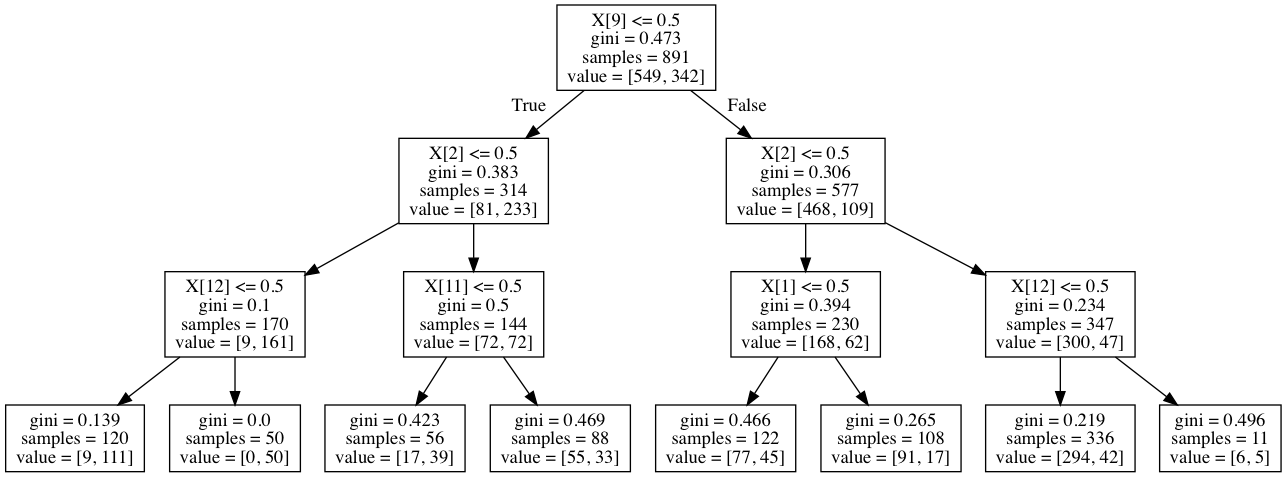

In [20]:
## 学習し直し
clf = tree.DecisionTreeClassifier(criterion='gini'
                                  , max_depth=3
                                  , min_samples_split=3
                                  , random_state=42)

clf.fit(X_train, y_train)


## 結果の可視化
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

指定し直したハイパーパラメータでモデルを学習し直しました。  
今回のモデルでの決定フローは上記のようになっています。  

機械学習でモデリングしたあとは、「どういう処理内容で、そのような推論結果が得られたか」といった「意味の解釈性」も検討する必要があります。  


## まとめ

2値分類タスクをやってみる流れで、機械学習のフローの流れの概要を学びました。  
今回は色々ざっくりとしかやっていないのですが、もし興味が出てきたら[kaggle](https://www.kaggle.com/competitions)で面白そうなコンペに取り組んでみましょう。

## おまけについて

上記で基本的な流れについて紹介したのですが、少しおまけも書きます。  
最近のテーブルデータの「回帰」や「分類」では、「GBTM」や「NN」を使ったものが人気です。  
なので、それらのモデルについても少し触ってみましょう。  

GBTMの売りは何より「手軽」で「処理が早く」、「結構精度もいい感じ」ということで「安い、早い、美味い」というものです。  
また、NNは「手はかかるものの、色々手を加えるとデータの特徴を詳しく学習してくれる」というものです。  
（いずれも個人的主観）  
これらは「アンサンブル」して使われることも多々あります。  

## おまけ(GBTM)

決定木分析をベースにしたアルゴリズムである「catboost」を使ってみましょう。  
「catboost」は回帰、分類のいずれにも使える教師あり学習です。  
(「xgboost」や「LightGBM」と似たようなアルゴリズムです。)  

本当はxgboostやLightGBMを使いたかったのですが、環境準備が面倒くさそうだったので妥協して「catboost」にしました。  
<span style="color: red; ">SageMakerの「xgboost」を使う時の参考にしてください。</span>  

In [21]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

# ホールドアウト検証(train:valid:test = 6:2:2)
cat_X_train, cat_X_test, cat_y_train, cat_y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
cat_X_train, cat_X_valid, cat_y_train, cat_y_valid = train_test_split(cat_X_train, cat_y_train, test_size=0.25, random_state=42)


# model
model_cat = CatBoostClassifier(iterations=100
                               , boosting_type = 'Plain'
                               , depth = 7
                               , use_best_model = True
                               , eval_metric = 'Accuracy'
                         )
fit_kwargs = dict(silent=True)    


# 学習
model_cat.fit(cat_X_train
              , cat_y_train
              , eval_set=(cat_X_valid, cat_y_valid)
              , **fit_kwargs)          


## スコアがベストだった際のスコア、イテレーション、を確認
print('ベストスコア(validation):',model_cat.best_score_['validation'])
print('ベストスコアを叩き出した際のイテレーション数:',model_cat.best_iteration_)


## 上記のvalidation-scoreで問題なさそうなら、テストデータでも確認
print('test-accuracy:',model_cat.score(X=cat_X_test,y=cat_y_test))


## 特徴量の重要度を確認
df_feature_importance = pd.DataFrame(model_cat.feature_importances_,columns=['feature_importance'])
df_feature_names = pd.DataFrame(model_cat.feature_names_,columns=['feature_names'])
_ = pd.merge(df_feature_importance,df_feature_names,left_index=True,right_index=True)
print(20*'=' + '特徴量の重要度で高い順から表示' + 20*'=')
_.sort_values('feature_importance', ascending=False)

ベストスコア(validation): {'Accuracy': 0.8258426966292135, 'Logloss': 0.43850219179148775}
ベストスコアを叩き出した際のイテレーション数: 3
test-accuracy: 0.7877094972067039
====================特徴量の重要度で高い順から表示====================


,feature_importance,feature_names
9,59.227493,Sex_male
2,24.809735,Pclass_3
4,3.944502,Parch_2
0,3.918807,SibSp
1,2.970370,Pclass_2
12,2.365259,"Fare_(51.233, 102.466]"
10,0.922708,Embarked_Q
24,0.691844,"Age_(32.252, 40.21]"
23,0.577183,"Age_(24.294, 32.252]"
16,0.385071,"Fare_(256.165, 307.398]"


## おまけ(NN)

参考までに、シンプルな「Neural Network」でのサンプルスクリプトも用意しておきます。  
興味がある方は下記もご参照ください。  

In [22]:
import keras
from keras.layers import Dense, BatchNormalization, Activation, Dropout, PReLU
from keras.models import Sequential
from keras import optimizers, regularizers
from keras import backend as K
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')


## データの分割
from sklearn.model_selection import train_test_split

x_trn, x_test, y_trn, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
x_trn, x_val, y_trn, y_val = train_test_split(x_trn, y_trn, test_size=0.25, random_state=1)



## モデルの定義
kernel_init = 'normal'
def Model(input_dim, activation, classes):
    model = Sequential()

    model.add(Dense(units=512
                    # , kernel_initializer = kernel_init
                    , kernel_initializer = keras.initializers.Ones()
                    , input_dim = input_dim
                    , kernel_regularizer=regularizers.l1(0.00001)
                   )
             )
    model.add(Activation(activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(units=128
                    , kernel_initializer = kernel_init
                   )
             ) 
    model.add(Activation(activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))    
    
    model.add(Dense(units=64
                    , kernel_initializer = kernel_init
                   )
             )    
    model.add(Activation(activation))
    model.add(BatchNormalization())

    model.add(Dense(units=32
                    , kernel_initializer = kernel_init
                   )
             )    
    model.add(Activation(activation))
    model.add(BatchNormalization())
    
    model.add(Dense(units=classes, kernel_initializer = kernel_init))    
    model.add(Activation(activation))
    
    return model


## インスタンス化
input_dim = X_train.shape[1]
activation = 'tanh'
classes = 1 #the output labels
batch_size = 64
epochs = 400


## 学習
## データを学習用と検証用に分割する

def train_nn(df_x_train:pd.core.frame.DataFrame, df_x_val:pd.core.frame.DataFrame, df_y_train:pd.core.series.Series, df_y_val:pd.core.series.Series):
    trn_x, trn_y, val_x, val_y = df_x_train, df_y_train.values.ravel(), df_x_val, df_y_val.values.ravel()
    
    print('check-data-size')
    print('train_x:{}'.format(trn_x.shape))
    print('train_y:{}'.format(trn_y.shape))
    print('val_x:{}'.format(val_x.shape))
    print('val_y:{}'.format(val_y.shape))
   
    #compile the model
    model = Model(input_dim = input_dim, activation = activation, classes = classes)
    cb_es = EarlyStopping(monitor='val_acc', patience=30, verbose=1, mode='auto')    
    optim = optimizers.Adam(lr = 0.001
                            , decay = 0.001 / batch_size
                           )
    model.compile(loss='binary_crossentropy', optimizer = optim, metrics = ['accuracy'])

    
    h = model.fit(x=trn_x
                  , y=trn_y
                  , epochs = epochs
                  , batch_size = batch_size
                  , validation_data = (val_x,val_y)
                  # , callbacks = [cb_es] # early_stoppingするならコメントアウトを外す
                  , verbose = 1
                 )   
    
    # validation-score
    print("valid-accuracy = {}".format(model.evaluate(x=val_x, y=y_val)[1]))
    
    return model, h
    

model, history = train_nn(df_x_train=x_trn, df_x_val=x_val, df_y_train=y_trn, df_y_val=y_val)

Using TensorFlow backend.


check-data-size
train_x:(534, 30)
train_y:(534,)
val_x:(178, 30)
val_y:(178,)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 534 samples, validate on 178 samples
Epoch 1/400
534/534 [==============================] - 1s 2ms/step - loss: 3.9714 - acc: 0.5000 - val_loss: 3.4702 - val_acc: 0.1910
Epoch 2/400
534/534 [==============================] - 0s 89us/step - loss: 3.9938 - acc: 0.4644 - val_loss: 3.1656 - val_acc: 0.4831
Epoch 3/400
534/534 [==============================] - 0s 90us/step - loss: 3.6420 - acc: 0.4794 - val_loss: 3.2509 - val_acc: 0.2022
Epoch 4/400
534/534 [==============================] - 0s 92us/step - loss: 3.8063 - acc: 0.5000 - val_loss: 3.2269 - val_acc: 0.2135
Epoch 5/400
534/534 [==============================] - 0s 98us/step - loss: 3.7845 - acc: 0.5094 - val_loss: 3.1992 - val_acc:

534/534 [==============================] - 0s 78us/step - loss: 1.2428 - acc: 0.6124 - val_loss: 0.8364 - val_acc: 0.6517
Epoch 45/400
534/534 [==============================] - 0s 80us/step - loss: 1.0181 - acc: 0.6086 - val_loss: 0.8722 - val_acc: 0.6517
Epoch 46/400
534/534 [==============================] - 0s 75us/step - loss: 0.9024 - acc: 0.6180 - val_loss: 0.8601 - val_acc: 0.6517
Epoch 47/400
534/534 [==============================] - 0s 71us/step - loss: 0.8669 - acc: 0.6124 - val_loss: 0.8088 - val_acc: 0.6517
Epoch 48/400
534/534 [==============================] - 0s 74us/step - loss: 0.8934 - acc: 0.6142 - val_loss: 0.8015 - val_acc: 0.6517
Epoch 49/400
534/534 [==============================] - 0s 74us/step - loss: 0.8910 - acc: 0.6124 - val_loss: 0.8041 - val_acc: 0.6517
Epoch 50/400
534/534 [==============================] - 0s 75us/step - loss: 0.8567 - acc: 0.6142 - val_loss: 0.8058 - val_acc: 0.6517
Epoch 51/400
534/534 [==============================] - 0s 75us/step

Epoch 105/400
534/534 [==============================] - 0s 72us/step - loss: 0.7606 - acc: 0.6292 - val_loss: 0.7568 - val_acc: 0.6573
Epoch 106/400
534/534 [==============================] - 0s 76us/step - loss: 0.7628 - acc: 0.6461 - val_loss: 0.7564 - val_acc: 0.6573
Epoch 107/400
534/534 [==============================] - 0s 72us/step - loss: 0.7687 - acc: 0.6461 - val_loss: 0.7561 - val_acc: 0.6573
Epoch 108/400
534/534 [==============================] - 0s 76us/step - loss: 0.7712 - acc: 0.6498 - val_loss: 0.7557 - val_acc: 0.6685
Epoch 109/400
534/534 [==============================] - 0s 74us/step - loss: 0.7572 - acc: 0.6461 - val_loss: 0.7549 - val_acc: 0.6742
Epoch 110/400
534/534 [==============================] - 0s 74us/step - loss: 0.7608 - acc: 0.6479 - val_loss: 0.7540 - val_acc: 0.6742
Epoch 111/400
534/534 [==============================] - 0s 75us/step - loss: 0.7573 - acc: 0.6348 - val_loss: 0.7535 - val_acc: 0.6854
Epoch 112/400
534/534 [=========================

534/534 [==============================] - 0s 77us/step - loss: 0.7261 - acc: 0.7097 - val_loss: 0.7057 - val_acc: 0.7135
Epoch 166/400
534/534 [==============================] - 0s 77us/step - loss: 0.7273 - acc: 0.7303 - val_loss: 0.7058 - val_acc: 0.7135
Epoch 167/400
534/534 [==============================] - 0s 75us/step - loss: 0.7267 - acc: 0.7116 - val_loss: 0.7067 - val_acc: 0.7135
Epoch 168/400
534/534 [==============================] - 0s 79us/step - loss: 0.7022 - acc: 0.7247 - val_loss: 0.7082 - val_acc: 0.7303
Epoch 169/400
534/534 [==============================] - 0s 78us/step - loss: 0.7162 - acc: 0.7172 - val_loss: 0.7070 - val_acc: 0.7303
Epoch 170/400
534/534 [==============================] - 0s 77us/step - loss: 0.7237 - acc: 0.7341 - val_loss: 0.7055 - val_acc: 0.7303
Epoch 171/400
534/534 [==============================] - 0s 76us/step - loss: 0.7151 - acc: 0.7247 - val_loss: 0.7023 - val_acc: 0.7135
Epoch 172/400
534/534 [==============================] - 0s 74

534/534 [==============================] - 0s 73us/step - loss: 0.7146 - acc: 0.6873 - val_loss: 0.7233 - val_acc: 0.6517
Epoch 226/400
534/534 [==============================] - 0s 78us/step - loss: 0.7629 - acc: 0.6592 - val_loss: 0.7253 - val_acc: 0.6517
Epoch 227/400
534/534 [==============================] - 0s 75us/step - loss: 0.7173 - acc: 0.6798 - val_loss: 0.7265 - val_acc: 0.6517
Epoch 228/400
534/534 [==============================] - 0s 78us/step - loss: 0.7360 - acc: 0.6835 - val_loss: 0.7262 - val_acc: 0.6517
Epoch 229/400
534/534 [==============================] - 0s 78us/step - loss: 0.6905 - acc: 0.7060 - val_loss: 0.7244 - val_acc: 0.6517
Epoch 230/400
534/534 [==============================] - 0s 75us/step - loss: 0.7211 - acc: 0.6966 - val_loss: 0.7235 - val_acc: 0.6517
Epoch 231/400
534/534 [==============================] - 0s 73us/step - loss: 0.7143 - acc: 0.6966 - val_loss: 0.7230 - val_acc: 0.6517
Epoch 232/400
534/534 [==============================] - 0s 74

534/534 [==============================] - 0s 78us/step - loss: 0.7112 - acc: 0.7341 - val_loss: 0.6923 - val_acc: 0.7079
Epoch 286/400
534/534 [==============================] - 0s 76us/step - loss: 0.7026 - acc: 0.7079 - val_loss: 0.6905 - val_acc: 0.7079
Epoch 287/400
534/534 [==============================] - 0s 76us/step - loss: 0.6954 - acc: 0.7022 - val_loss: 0.6900 - val_acc: 0.7079
Epoch 288/400
534/534 [==============================] - 0s 79us/step - loss: 0.6997 - acc: 0.7191 - val_loss: 0.6885 - val_acc: 0.7079
Epoch 289/400
534/534 [==============================] - 0s 74us/step - loss: 0.6940 - acc: 0.7097 - val_loss: 0.6875 - val_acc: 0.7079
Epoch 290/400
534/534 [==============================] - 0s 75us/step - loss: 0.7035 - acc: 0.6966 - val_loss: 0.6860 - val_acc: 0.7079
Epoch 291/400
534/534 [==============================] - 0s 76us/step - loss: 0.6768 - acc: 0.7285 - val_loss: 0.6849 - val_acc: 0.7079
Epoch 292/400
534/534 [==============================] - 0s 77

534/534 [==============================] - 0s 77us/step - loss: 0.6805 - acc: 0.7247 - val_loss: 0.6703 - val_acc: 0.7247
Epoch 346/400
534/534 [==============================] - 0s 78us/step - loss: 0.6660 - acc: 0.7266 - val_loss: 0.6681 - val_acc: 0.7247
Epoch 347/400
534/534 [==============================] - 0s 77us/step - loss: 0.6828 - acc: 0.7210 - val_loss: 0.6680 - val_acc: 0.7247
Epoch 348/400
534/534 [==============================] - 0s 74us/step - loss: 0.6568 - acc: 0.7509 - val_loss: 0.6680 - val_acc: 0.7247
Epoch 349/400
534/534 [==============================] - 0s 75us/step - loss: 0.6703 - acc: 0.7322 - val_loss: 0.6670 - val_acc: 0.7247
Epoch 350/400
534/534 [==============================] - 0s 78us/step - loss: 0.6667 - acc: 0.7247 - val_loss: 0.6648 - val_acc: 0.7247
Epoch 351/400
534/534 [==============================] - 0s 77us/step - loss: 0.6673 - acc: 0.7266 - val_loss: 0.6632 - val_acc: 0.7247
Epoch 352/400
534/534 [==============================] - 0s 75

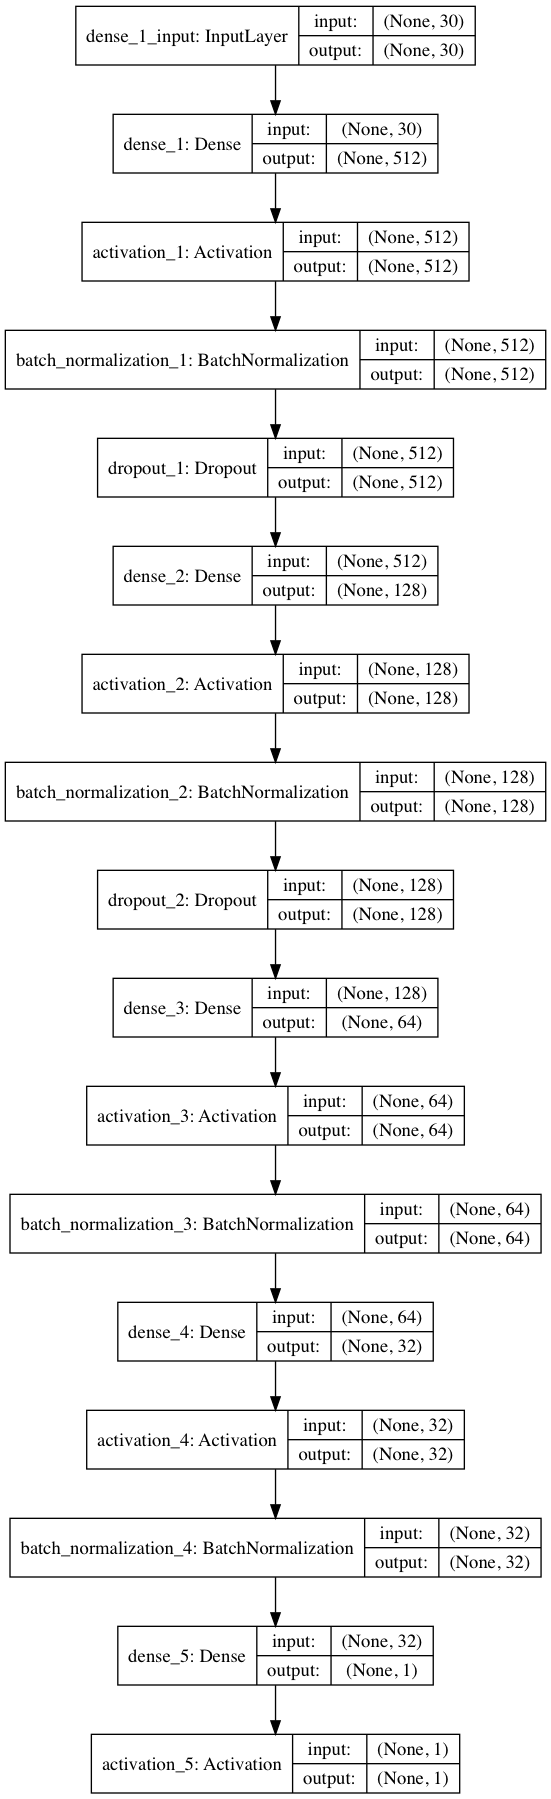

In [27]:
## modelの可視化
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, )

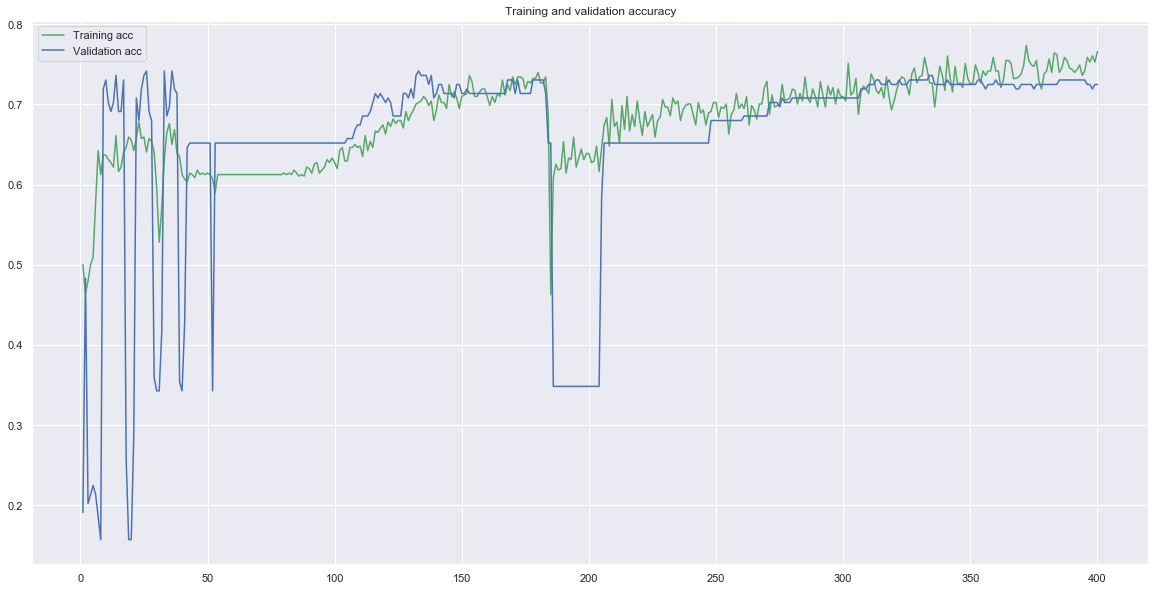

<Figure size 432x288 with 0 Axes>

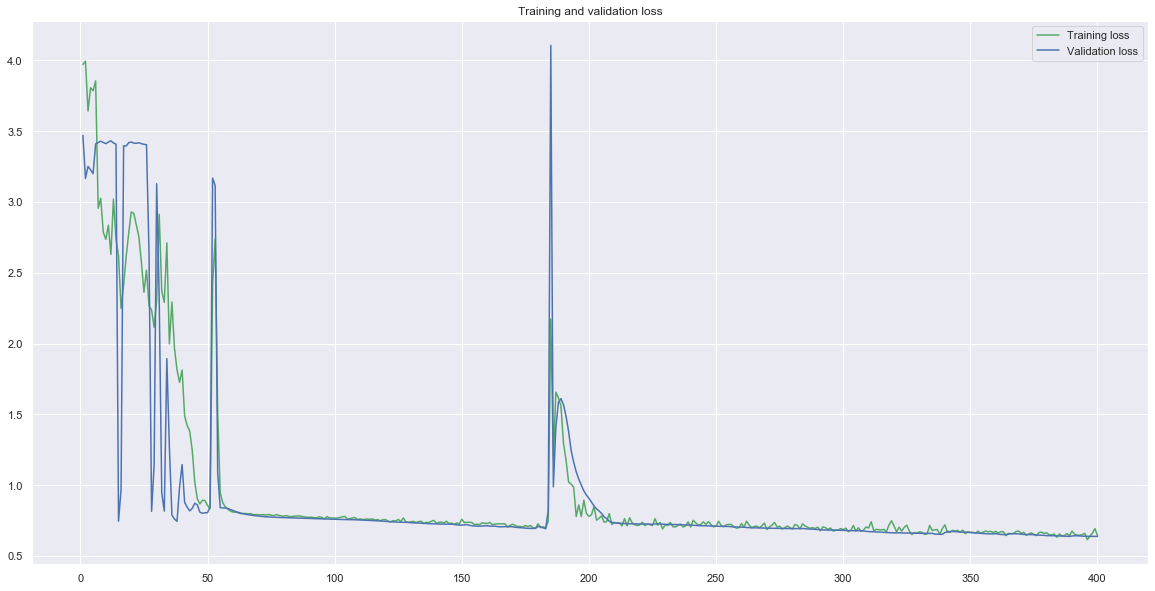

In [24]:
## 学習過程の可視化

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(figsize=(20, 10))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

fig, axs = plt.subplots(figsize=(20, 10))
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
## validation-dataでハイパーパラメータ をチューニングして、良さげだったら最後の最後にtestデータで確認しよう!!!
## validationとtestのスコアに差があるようだと、それは「validationデータに過学習」している状態なのでやり直しだよ!!!

print("test-accuracy = {}".format(model.evaluate(x=x_test, y=y_test)[1]))

179/179 [==============================] - 0s 52us/step
test-accuracy = 0.7374301682637391


## おまけ(SageMakerのビルドインアルゴリズム)
SageMakerの各種ビルトインアルゴリズムの使い所について適当にまとめました。

- [BlazingText](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/blazingtext.html)
    - 教師あり、教師なしのいずれのモードも用意されている（裏では違うアルゴリズムが動く）
    - テキストデータに対して、「テキスト分類（教師あり）」、「単語の埋め込み表現獲得（教師なし）」に使う
    - 単語の埋め込み表現を取得したのちに、回帰や分類、翻訳等の色々な用途に使える。
- [DeepAR](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/deepar.html)
    - 教師ありの回帰
    - 時系列の予測に使う
    - テーブルデータが対象
- [Factorization Machines](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/fact-machines.html)
    - 回帰、分類のいずれにも使える教師あり学習
    - テーブルデータに使う
    - レコメンドに使われることが多い
- [image classification](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/image-classification.html)    
    - 教師ありの分類。画像データに使う
    - 画像に写っているものに応じて、画像を特定のクラスに「分類」する。
    - マルチラベル対応しているので、1枚の画像に色々なクラスのものが写っていても「それぞれのクラスに応じた」スコアを計算できる
    - 単に「画像に何が写っているか」がわかればいいときはこれを使う
- [IP Insights](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/ip-insights.html)    
    - 教師なしの異常検知
    - テーブルデータに使う
    - 従来のIPアドレスの履歴から、「今まであまりみたことない挙動」を見つけだして、「異常」と判別する
    - 正直、使い所がかなりFIXされたアルゴリズムだなぁ...と思う
- [k-means](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/k-means.html)    
    - 教師なしのクラスタリング
    - テーブルデータに対して、「適当な数のクラスターにいい感じに分割したいなぁ」といった時に使うアルゴリズム
    - 顧客セグメント、店舗セグメント等を検討する時に利用する
- [k-nn(K 最近傍探索)](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/k-nearest-neighbors.html)    
    - 教師ありで、回帰、分類の両方に使える
    - 「自分とよく似ているk個のデータの目的変数」を使って予測するもの
    - 「埋め込み表現」が流行ったおかげで、「画像検索」、「レコメンド」等色々なところで使われるようになってきた
    - 計算量を削減するためにIndexを貼ったりする点も重要
- [LDA(潜在的ディリクレ配分)](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/lda.html) 
    - 教師なしのテキストクラスタリング
    - 「Webサイトの口コミを適当に分割して、顧客のインサイトをクラスタリング」、とかに使う
- [linear-learner(線形回帰)](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/linear-learner.html)
    - 教師あり回帰
    - 機械学習の基本中の基本
    - 説明不要
- [Neural Topic Model(ニューラルトピックモデル)](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/ntm.html)
    - 教師なしのクラスタリング
    - LDAと似たようなもの
- [Object2Vec](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/object2vec.html)
    - 教師ありで回帰も分類もいける
    - レコメンド、テキスト分類、埋め込み表現獲得に使える
    - 割と色々な場面で利用することができそう
- [object detection(SSD)](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/object-detection.html)    
    - 教師あり
    - 画像データに対して「どこに何が写っているか」を推論する
    - 「どこに」については、厳密には「物体の写っている四角形の頂点」を返すことになるので「ピクセル単位で位置を特定したいんや...」という場合は「semantic segmentation」を使う。
    - 逆に「画像中に写っているか、写っていないか、がわかればいいんじゃい」という場合は「image classification」を使えばよろし。
- [PCA(主成分分析)](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/pca.html)    
    - 教師なしの次元削減
    - テーブルデータに使う    
    - 「特徴量多すぎ...」っていう場合に「情報量をできるだけ保持したままで特徴量数を減らす」際に使う
- [randomcutforest](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/randomcutforest.html)
    - 教師なしの異常検知
    - テーブルデータに使う
    - 「異常時のデータとか殆どないけど異常検知したい！！！」って時に使う
- [semantic-segmentation](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/semantic-segmentation.html)
    - 教師ありで、画像データに対して使う
    - 画像中の「どこに（ピクセル単位）」、「何が」写っているかを検出する
    - 医療現場で「この写真のこの部分が癌です」とかそういうのを検出するのに使われている。
- [Sequence to Sequence](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/seq-2-seq.html)    
    - 教師ありで、自然言語データに使う
    - 翻訳モデルとかに使われる(回帰のような処理をして、「次はこの単語を出すと言語として適しているな」とかを推論している形)
    - 「埋め込み表現の獲得」に使われることも多い。「埋め込み表現」が獲得できたら、そのあとはテキスト分類や、ブログ記事のタグ付け等、色々できる
- [XGBoost](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/xgboost.html)
    - 教師ありで、回帰、分類のいずれにも使える
    - テーブルデータに使う